In [1]:
#!pip install lifelines

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn_pandas import DataFrameMapper
import torch
from torch.utils.data import DataLoader, Dataset
from torch import nn
from lifelines.utils import concordance_index
from torchvision import transforms, utils
import h5py
import torchvision.utils
 
from torch.utils.tensorboard import SummaryWriter

In [319]:
class SurvivalDataset(Dataset):
    def __init__(self, h5_file, is_train):
        self.X, self.e, self.y = self._read_h5_file(h5_file, is_train)
        self._normalize()
        if is_train:
            print('train data => load {} samples'.format(self.X.shape[0]))
        else :
            print('test data => load {} samples'.format(self.X.shape[0]))

    def _read_h5_file(self, h5_file, is_train):
        split = 'train' if is_train else 'test'
        with h5py.File(h5_file, 'r') as f:
            X = f[split]['x'][()]
            e = f[split]['e'][()].reshape(-1, 1)
            y = f[split]['t'][()].reshape(-1, 1)
        return X, e, y

    def _normalize(self):  
        self.X = (self.X-self.X.min(axis=0)) /  (self.X.max(axis=0)-self.X.min(axis=0))

    def __getitem__(self, item):
        X_item = self.X[item] 
        e_item = self.e[item] 
        y_item = self.y[item] 

        X_tensor = torch.from_numpy(X_item)
        e_tensor = torch.from_numpy(e_item)
        y_tensor = torch.from_numpy(y_item)
        return X_tensor, y_tensor, e_tensor

    def __len__(self):
        return self.X.shape[0]
    
#     def shape(self):
#         return self.X.shape[1].item()

In [320]:
path = '../input/bmc-data/gbsg_cancer_train_test.h5'
train_dataset = SurvivalDataset(path, is_train = True)
eval_dataset = SurvivalDataset(path, is_train = False)

train data => load 1546 samples
test data => load 686 samples


In [321]:
train_dataloader = DataLoader(train_dataset, batch_size = len(train_dataset))
val_dataloader = DataLoader(eval_dataset, batch_size = len(eval_dataset))
train_dataset.X.shape[1]

7

In [322]:
class linearCPH(nn.Module):
    def __init__(self):
        super(linearCPH, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(in_features, out_features)
        )
    def forward(self, x):
        x = self.model(x)
        return x
    
class CPH(nn.Module):
    def __init__(self):
        super(CPH, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(in_features, 8, bias=True),
            nn.BatchNorm1d(8, eps = 1e-05, momentum = 0.1, affine = True, track_running_stats = True),
            nn.SELU(),
            nn.Dropout(p=0.661, inplace=False),
            nn.Linear(8, 1, bias=True),
            nn.BatchNorm1d(1, eps = 1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.SELU(),
        )
    def forward(self, x):
        x = self.model(x)
        return x

In [323]:
def c_index(risk_pred, y, e):
   
    if not isinstance(y, np.ndarray):
        y = y.detach().cpu().numpy()
    if not isinstance(risk_pred, np.ndarray):
        risk_pred = risk_pred.detach().cpu().numpy()
    if not isinstance(e, np.ndarray):
        e = e.detach().cpu().numpy()
    return concordance_index(y, risk_pred, e)

In [324]:
def adjust_learning_rate(optimizer, epoch, lr, lr_decay_rate):
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr / (1+epoch*lr_decay_rate)
    return optimizer.param_groups[0]['lr']

In [325]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
in_features = train_dataset.X.shape[1]
out_features = 1
model = CPH()
model = model.to(device)

In [326]:

#L2 Regularization
class Regularization(object):
    def __init__(self, order, weight_decay):     
        super(Regularization, self).__init__()
        self.order = order
        self.weight_decay = weight_decay
    def __call__(self, model):
        reg_loss = 0
        for name, w in model.named_parameters():
            if 'weight' in name:
                reg_loss = reg_loss + torch.norm(w, p=self.order)
        reg_loss = self.weight_decay * reg_loss
        return reg_loss
    
#partial likelihood
class NegativeLogLikelihood(nn.Module):
    def __init__(self, config):
        super(NegativeLogLikelihood, self).__init__()
        self.L2_reg = meta_L2
        self.reg = Regularization(order = 2, weight_decay = self.L2_reg)
    def forward(self, risk_pred, y, e, model):
        mask = torch.ones(y.shape[0], y.shape[0])
        mask[(y.T - y) > 0] = 0
        mask = mask.to(device)
        log_loss = torch.exp(risk_pred) * mask
        log_loss = torch.sum(log_loss, dim=0,keepdim = False) / torch.sum(mask, dim=0, keepdim = False)
        log_loss = torch.log(log_loss).reshape(-1, 1)
        neg_log_loss = -torch.sum((risk_pred-log_loss) * e) / torch.sum(e)
        l2_loss = self.reg(model)
        return neg_log_loss + l2_loss

In [327]:
meta_L2 = 0
learning_rate = 1e-2
lr_decay_rate = 4.169e-3
optimizer = torch.optim.NAdam(model.parameters(), lr = learning_rate)
loss = NegativeLogLikelihood(model)
loss = loss.to(device)

#optimizer = optimizer.to(device)

In [328]:
total_train_step = 0 
total_test_step = 0
epoch = 500

train_best_c_index = 0
val_best_c_index = 0
train_c_index = []
val_c_index = []
train_epoch_list = []
valid_epoch_list = []
train_loss_list = []
valid_loss_list = []
#get_target = lambda df: (df['duration'].values, df['event'].values)

#writer = SummaryWriter("logs_train")
for i in range(epoch):
    
    lr = adjust_learning_rate(optimizer, i, learning_rate, lr_decay_rate)
    if(i % 10 == 0):
        train_epoch_list.append(i + 1)
    valid_epoch_list.append(i + 1)
    model.train()
    for X, y, e in train_dataloader:
       # print("--------第{}轮训练--------".format(i + 1))
        X = X.to(device)
        y = y.to(device)
        e = e.to(device)
        risk_pred = model(X)
        risk_pred = risk_pred.to(device)
        train_loss = loss(risk_pred, y, e, model)
        if(i % 10 == 0):
            train_loss_list.append(train_loss.cpu().detach().numpy())
        train_c = c_index(-risk_pred, y, e)
        train_c_index.append(train_c)
        if(train_best_c_index < train_c):
            train_best_c_index = train_c
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()
        total_train_step = total_train_step + 1
        
        #writer.add_scalar("train_loss", train_loss.item(), total_train_step)
#         print("Train：训练次数：{}, train_loss:{:.8f}, train_c:{:.8f}".format(total_train_step, train_loss.item(), 
#                                                           train_c.item()))
        
    model.eval()
    for X, y, e in val_dataloader:
        X = X.to(device)
        y = y.to(device)
        e = e.to(device)
        with torch.no_grad():
            risk_pred = model(X)
            risk_pred = risk_pred.to(device)
            valid_loss = loss(risk_pred, y, e, model)
            valid_loss_list.append(valid_loss.cpu().detach().numpy())
            valid_c = c_index(-risk_pred, y, e)
            val_c_index.append(valid_c)
            if(val_best_c_index < valid_c):
                val_best_c_index = valid_c
        print('\nEpoch: {}\tTrain_Loss: {:.8f}({:.8f})\tTrain_c-index: {:.8f}({:.8f})\tlr: {:g}'.format(
             i + 1, train_loss.item(), valid_loss.item(), train_c, valid_c, lr), end='', flush=False)
        #writer.add_scalar("valid_loss", valid_loss.item(), total_test_step)
        #total_test_step = total_test_step + 1
    



Epoch: 1	Train_Loss: 0.57397878(-0.01423704)	Train_c-index: 0.51401590(0.56132019)	lr: 0.01
Epoch: 2	Train_Loss: 0.51315492(-0.01978354)	Train_c-index: 0.54441848(0.57816069)	lr: 0.00995848
Epoch: 3	Train_Loss: 0.52042478(-0.02821134)	Train_c-index: 0.52971836(0.59584285)	lr: 0.00991731
Epoch: 4	Train_Loss: 0.31157684(-0.03465940)	Train_c-index: 0.55922793(0.60122340)	lr: 0.00987647
Epoch: 5	Train_Loss: 0.29159427(-0.04079851)	Train_c-index: 0.55678245(0.60347030)	lr: 0.00983598
Epoch: 6	Train_Loss: 0.22962110(-0.04584979)	Train_c-index: 0.57136729(0.60401136)	lr: 0.00979581
Epoch: 7	Train_Loss: 0.32264054(-0.05098421)	Train_c-index: 0.54928570(0.60604785)	lr: 0.00975596
Epoch: 8	Train_Loss: 0.31076324(-0.05470085)	Train_c-index: 0.56266685(0.60824967)	lr: 0.00971644
Epoch: 9	Train_Loss: 0.23615059(-0.05703945)	Train_c-index: 0.57277532(0.60938439)	lr: 0.00967724
Epoch: 10	Train_Loss: 0.23955649(-0.06117671)	Train_c-index: 0.56671132(0.61149603)	lr: 0.00963836
Epoch: 11	Train_Loss: 0.

In [329]:
train_c_index = np.array(train_c_index)
val_c_index = np.array(val_c_index)
train_mean = train_c_index.mean()
train_std = train_c_index.std()
val_mean = val_c_index.mean()
val_std = val_c_index.std()

print("\nTrain c-index's avg:{:.8f}({:.8f})\tVal c-index's avg:{:.8f}({:.8f})".format(train_mean, 
                                                                                      train_best_c_index,
                                                                                      val_mean,
                                                                                      val_best_c_index))


print("\nTrain c-index's std:{:.8f}\tVal c-index's std:{:.8f}".format(train_std, val_std))



Train c-index's avg:0.64104286(0.66327557)	Val c-index's avg:0.66267918(0.67207226)

Train c-index's std:0.02001807	Val c-index's std:0.01575543


In [330]:
from scipy import stats
conf_intveral = stats.norm.interval(0.95, loc = val_mean, scale = val_std)
print(val_mean)
print(conf_intveral)

0.6626791811951425
(0.6317991141210696, 0.6935592482692153)


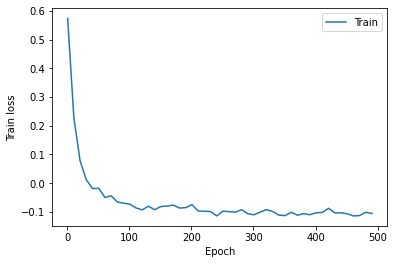

In [331]:
plt.plot(train_epoch_list, train_loss_list)
plt.xlabel("Epoch")
plt.ylabel("Train loss")
plt.legend(['Train'])
plt.show()
b = np.array(train_loss_list)

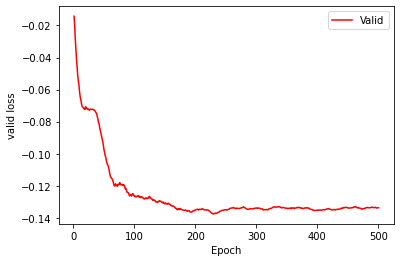

In [332]:
plt.plot(valid_epoch_list, valid_loss_list, 'r')
plt.xlabel("Epoch")
plt.ylabel("valid loss")
plt.legend(['Valid'])
plt.show()

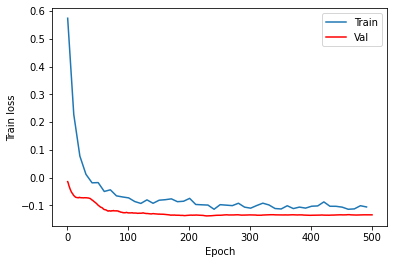

In [333]:
plt.plot(train_epoch_list, train_loss_list, valid_epoch_list, valid_loss_list, 'r')
plt.xlabel("Epoch")
plt.ylabel("Train loss")
plt.legend(['Train', 'Val'])
plt.show()
